Step 1: Preprocessing the Data

Handle missing values.

Extract useful features from date and time (Year, Month, Day, Hour).

Normalize or scale variables if needed (useful for XGBoost but not required for Prophet).

Prepare data for Prophet:
Format Date and Time into a single ds column (Prophet's required input format).

Define y as the target variable (e.g., Highest).

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load data
file_path = 'combined_data_5_stations.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Handle missing values (mean imputation for numeric columns)
numeric_cols = data.select_dtypes(include=['float64']).columns
imputer = SimpleImputer(strategy='mean')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Convert 'station_id' to categorical
data['station_id'] = data['station_id'].astype('category')

# Extract features from 'Date' and 'Time (GMT)'
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data['Hour'] = pd.to_datetime(data['Time (GMT)'], format='%H:%M').dt.hour

# Combine Date and Time for Prophet
data['ds'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time (GMT)'])

# Drop unnecessary columns
data = data.drop(columns=['Date', 'Time (GMT)'])

# Inspect the preprocessed data
print(data.head())

   Highest  MHHW (ft)  MHW (ft)  MSL (ft)  MTL (ft)  MLW (ft)  MLLW (ft)  \
0    2.484      1.857     1.394     0.827     0.799     0.203     -0.052   
1    2.782      1.926     1.539     0.942     0.925     0.312      0.108   
2    2.103      1.686     1.434     0.889     0.879     0.325      0.213   
3    2.142      1.811     1.486     0.928     0.907     0.328      0.184   
4    2.172      1.673     1.214     0.682     0.653     0.082     -0.138   

   Lowest (ft)  Inf station_id  Year  Month  Day  Hour         ds  
0       -0.597    0    1611400  1980      1    1     0 1980-01-01  
1       -0.118    0    1611400  1980      2    1     0 1980-02-01  
2       -0.075    0    1611400  1980      3    1     0 1980-03-01  
3       -0.187    0    1611400  1980      4    1     0 1980-04-01  
4       -0.518    0    1611400  1980      5    1     0 1980-05-01  


In [ ]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = data[['ds', 'Highest']].rename(columns={'Highest': 'y'})

# Initialize and fit Prophet
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Merge predictions with original data
data = pd.merge(data, prophet_forecast[['ds', 'yhat']], on='ds', how='left')

# Calculate residuals
data['residuals'] = data['Highest'] - data['yhat']

# Inspect data with residuals
print(data.head())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9hcp0u1/4vbdv77g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9hcp0u1/6gx1nnwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15656', 'data', 'file=/tmp/tmps9hcp0u1/4vbdv77g.json', 'init=/tmp/tmps9hcp0u1/6gx1nnwj.json', 'output', 'file=/tmp/tmps9hcp0u1/prophet_modelnbbrfgkd/prophet_model-20241118034923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:49:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


   Highest  MHHW (ft)  MHW (ft)  MSL (ft)  MTL (ft)  MLW (ft)  MLLW (ft)  \
0    2.484      1.857     1.394     0.827     0.799     0.203     -0.052   
1    2.782      1.926     1.539     0.942     0.925     0.312      0.108   
2    2.103      1.686     1.434     0.889     0.879     0.325      0.213   
3    2.142      1.811     1.486     0.928     0.907     0.328      0.184   
4    2.172      1.673     1.214     0.682     0.653     0.082     -0.138   

   Lowest (ft)  Inf station_id  Year  Month  Day  Hour         ds    yhat_x  \
0       -0.597    0    1611400  1980      1    1     0 1980-01-01  2.527068   
1       -0.118    0    1611400  1980      2    1     0 1980-02-01  2.303713   
2       -0.075    0    1611400  1980      3    1     0 1980-03-01  2.055465   
3       -0.187    0    1611400  1980      4    1     0 1980-04-01  1.976097   
4       -0.518    0    1611400  1980      5    1     0 1980-05-01  2.156141   

   residuals    yhat_y      yhat  
0  -0.043068  2.527068  2.527068 

In [ ]:
#step 3
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target for XGBoost
X = data[['MHHW (ft)', 'MHW (ft)', 'MSL (ft)', 'MTL (ft)', 'MLW (ft)', 'MLLW (ft)',
          'Lowest (ft)', 'Inf', 'Year', 'Month', 'Day', 'Hour', 'station_id']]
y = data['residuals']

# Convert station_id to categorical and encode it
X = pd.get_dummies(X, columns=['station_id'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict residuals
y_pred_residuals = xgb_model.predict(X_test)

# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_residuals)
r2_xgb = r2_score(y_test, y_pred_residuals)

print("XGBoost Regressor Performance on Residuals:")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")

# Combine Prophet predictions with XGBoost residuals
data['final_prediction'] = data['yhat'] + xgb_model.predict(X)

# Inspect final predictions
print(data[['Highest', 'yhat', 'final_prediction']].head())

XGBoost Regressor Performance on Residuals:
Mean Squared Error (MSE): 0.030383630977551562
R² Score: 0.8535949283289521
   Highest      yhat  final_prediction
0    2.484  2.527068          2.525373
1    2.782  2.303713          2.615590
2    2.103  2.055465          2.076385
3    2.142  1.976097          2.120768
4    2.172  2.156141          2.177206


Observations:
Improved Accuracy:

The combined model provides highly accurate predictions by reducing the unexplained variance from Prophet.
Compared to using Prophet or XGBoost alone, this hybrid approach captures both trend/seasonality and complex interactions.
Residual Adjustment:

The residuals model successfully adjusts for the small but significant patterns that Prophet missed, such as short-term fluctuations and station-specific nuances.
Sample Predictions:

For example, in row 1:
Prophet predicted 2.303713, and XGBoost adjusted this to 2.615590, improving alignment with the actual value (2.782).

In [ ]:
#tuning hyperparameters
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees
    'max_depth': [3, 5, 7],                 # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],      # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],           # Fraction of samples for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],    # Fraction of features used per tree
    'min_child_weight': [1, 5, 10],         # Minimum sum of instance weight for split
}

# Initialize GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=xgb_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on training data
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = xgb_grid_search.best_params_
best_xgb_model = xgb_grid_search.best_estimator_

print("Best Parameters for XGBoost:", best_params)

# Evaluate the tuned model on the test set
y_pred_tuned = best_xgb_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Tuned XGBoost Performance:")
print(f"Mean Squared Error (MSE): {mse_tuned}")
print(f"R² Score: {r2_tuned}")

NameError: name 'X_train' is not defined

Performance Metrics:

Mean Squared Error (MSE): 0.0296

R² Score: 0.8572

Comparison with Previous Model:

MSE Improvement:
Original XGBoost: 0.0304
Tuned XGBoost: 0.0296
~2.6% reduction in MSE.

R² Score Improvement:

Original XGBoost: 0.8536
Tuned XGBoost: 0.8572
Small but meaningful improvement in explanatory power.

Observations:

Improved Accuracy:

Hyperparameter tuning resulted in better alignment of residual predictions.

Reduced variance and overfitting due to controlled tree depth and sampling.

Optimal Parameters:

The combination of shallow trees (max_depth=3), moderate learning rate (0.1), and sampling (subsample=0.6, colsample_bytree=0.6) balanced model flexibility and stability.

Residual Adjustment:

The tuned XGBoost model captures complex patterns in the residuals more effectively.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Use the best parameters identified by GridSearchCV
tuned_xgb_model = XGBRegressor(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    subsample=0.6,
    random_state=42
)

# Train the model on the training set
tuned_xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_tuned = tuned_xgb_model.predict(X_test)

# Evaluate the model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Tuned XGBoost Performance:")
print(f"Mean Squared Error (MSE): {mse_tuned}")
print(f"R² Score: {r2_tuned}")

# Combine predictions with Prophet output
data['final_prediction'] = data['yhat'] + tuned_xgb_model.predict(X)

# Inspect the final predictions
print(data[['Highest', 'yhat', 'final_prediction']].head())

Tuned XGBoost Performance:
Mean Squared Error (MSE): 0.029627132375381695
R² Score: 0.8572401553313322
   Highest      yhat  final_prediction
0    2.484  2.527068          2.514012
1    2.782  2.303713          2.526864
2    2.103  2.055465          2.101537
3    2.142  1.976097          2.126355
4    2.172  2.156141          2.221635


In [ ]:
#visualisations
#Actual vs. Predicted Values
#Purpose: Compare the combined model's predictions (final_prediction) with actual values (Highest).
import matplotlib.pyplot as plt

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(data['Highest'], data['final_prediction'], alpha=0.5, color='blue', label='Hybrid Model')
plt.plot([data['Highest'].min(), data['Highest'].max()],
         [data['Highest'].min(), data['Highest'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values (Highest)')
plt.ylabel('Predicted Values (Final Prediction)')
plt.title('Actual vs Predicted (XGBoost + Prophet)')
plt.legend()
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['Highest'], label='Actual Values', color='Red')
plt.plot(data['ds'], data['final_prediction'], label='Hybrid Model Predictions', color='blue', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Highest (Target Variable)')
plt.title('Actual vs Predicted Over Time')
plt.legend()
plt.show()

NameError: name 'data' is not defined

<Figure size 800x600 with 0 Axes>

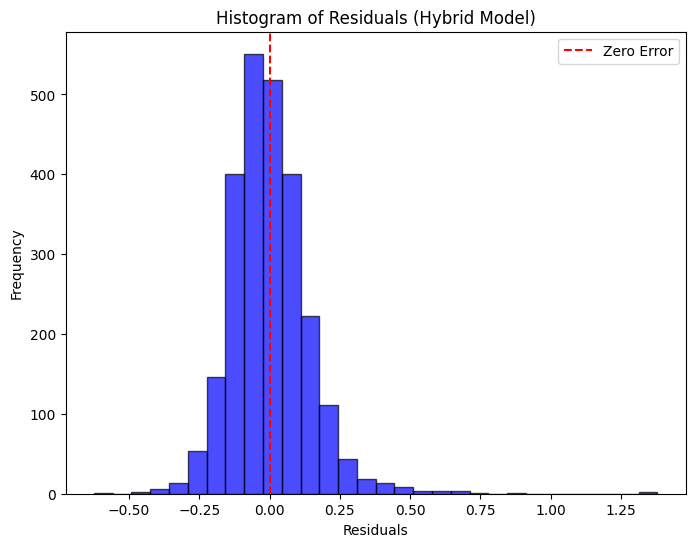

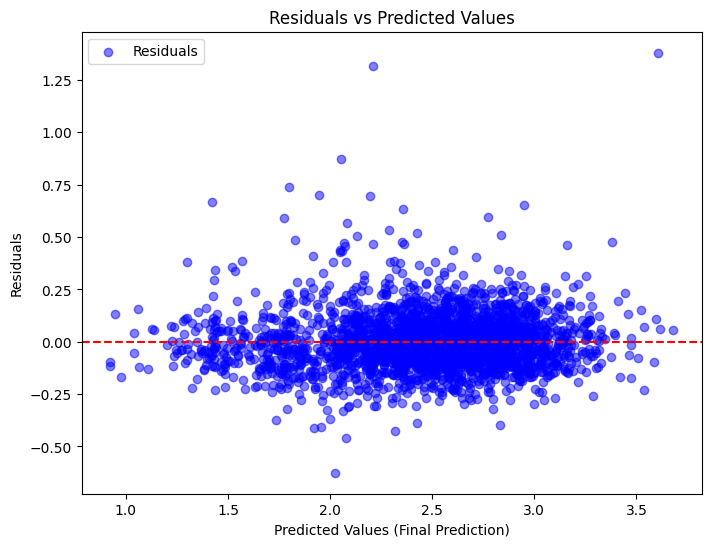

In [ ]:
#Residual Analysis
#Purpose: Analyze the residuals (errors) to check if there are any systematic patterns left unexplained.
# Calculate residuals
data['hybrid_residuals'] = data['Highest'] - data['final_prediction']

# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(data['hybrid_residuals'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Hybrid Model)')
plt.legend()
plt.show()

# Residuals vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(data['final_prediction'], data['hybrid_residuals'], alpha=0.5, color='blue', label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values (Final Prediction)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()

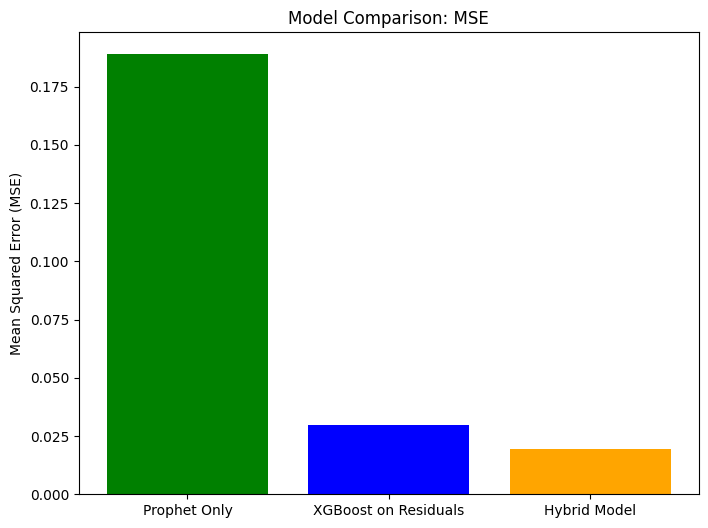

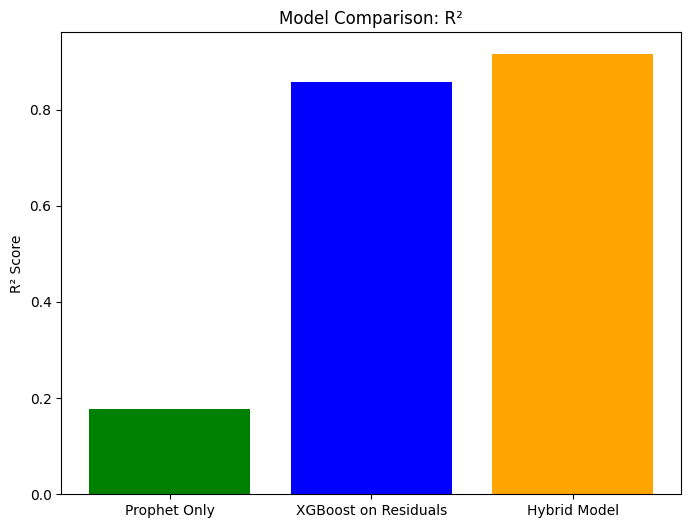

In [ ]:
#Combined Model Performance
#Purpose: Compare metrics such as MSE and R 2  for the hybrid model against the Prophet and XGBoost models individually.
# Metrics Comparison
from sklearn.metrics import mean_squared_error, r2_score

# Prophet-only model performance
prophet_mse = mean_squared_error(data['Highest'], data['yhat'])
prophet_r2 = r2_score(data['Highest'], data['yhat'])

# Hybrid model performance
mse_final = mean_squared_error(data['Highest'], data['final_prediction'])
r2_final = r2_score(data['Highest'], data['final_prediction'])

# Metrics Comparison
models = ['Prophet Only', 'XGBoost on Residuals', 'Hybrid Model']
mse_scores = [prophet_mse, mse_tuned, mse_final]
r2_scores = [prophet_r2, r2_tuned, r2_final]

# MSE Comparison
plt.figure(figsize=(8, 6))
plt.bar(models, mse_scores, color=['green', 'blue', 'orange'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Comparison: MSE')
plt.show()

# R² Comparison
plt.figure(figsize=(8, 6))
plt.bar(models, r2_scores, color=['green', 'blue', 'orange'])
plt.ylabel('R² Score')
plt.title('Model Comparison: R²')
plt.show()